In [1]:
import pandas as pd
from glob import glob

root_path = 'path/to/your/dataset'

# Get list of files
files = glob(f'{root_path}data/times/times_txt/*.txt')
print(len(files))

# Read the rec_times_host.txt file and process the data
data = []
with open(f'{root_path}data/times/rec_times_host.txt', 'r') as txt:
    lines = txt.readlines()
    for line in lines:
        file, date, time = line.split()
        camera = file.split('_')[0]
        group = file.split('/')[1]
        combination = file.split('/')[-1].split('.')[0]
        subject = combination.split('S')[-1].split('A')[0]
        action = combination.split('A')[-1].split('D')[0]
        speed = combination.split('D')[-1].split('.')[0]
        data.append({
            'id': combination, 
            'camera': camera, 
            'group': group, 
            'combination': combination, 
            'subject': subject, 
            'action': action, 
            'speed': speed, 
            'date': date, 
            'rec_time': time, 
            'path': f'data/times_txt/{group}_{combination}.txt'
        })

# Create DataFrame
df_rec = pd.DataFrame(data)
print(f"Total rows before dropping duplicates: {len(df_rec)}")

# Convert rec_time to datetime
df_rec['rec_time_temp'] = pd.to_datetime(df_rec['rec_time'], format='%H:%M:%S.%f')

# Sort by path and rec_time in descending order
df_rec = df_rec.sort_values(by=['path', 'rec_time_temp'], ascending=[True, False])

# Drop duplicates, keeping the first occurrence (highest rec_time)
df_rec = df_rec.drop_duplicates(subset=['path'], keep='first')
print(f"Total rows after dropping duplicates: {len(df_rec)}")

df_rec = df_rec.drop(columns=['rec_time_temp'])

# Display the first few rows
df_rec.head()


4194
Total rows before dropping duplicates: 9016
Total rows after dropping duplicates: 4026


,id,camera,group,combination,subject,action,speed,date,rec_time,path
2887,C1S10A0D1,C1,C1S10,C1S10A0D1,10,0,1,2024-06-11,16:17:03.418,times_txt/C1S10_C1S10A0D1.txt
2903,C1S10A1D1,C1,C1S10,C1S10A1D1,10,1,1,2024-06-11,16:21:12.557,times_txt/C1S10_C1S10A1D1.txt
2909,C1S10A1D2,C1,C1S10,C1S10A1D2,10,1,2,2024-06-11,16:22:03.466,times_txt/C1S10_C1S10A1D2.txt
2926,C1S10A3D1,C1,C1S10,C1S10A3D1,10,3,1,2024-06-11,16:23:14.598,times_txt/C1S10_C1S10A3D1.txt
2941,C1S10A3D2,C1,C1S10,C1S10A3D2,10,3,2,2024-06-11,16:24:16.155,times_txt/C1S10_C1S10A3D2.txt


In [15]:
from datetime import datetime, timedelta
from fastprogress import progress_bar

idxs = []
paths = []
times_new = []
combinations = []
cams = []

for idx, row in progress_bar(df_rec.iterrows(), total=len(df_rec)):
    path = f'{root_path}{row['path']}'
    time_str = row['rec_time']
    combination = row['combination']
    cam = combination[:2]
    subject = f"S{combination.split('S')[-1].split('A')[0]}"
    action = f"A{combination.split('A')[-1].split('D')[0]}"
    speed = f"D{combination.split('D')[-1]}"
    try:
        with open(path, 'r') as txt:
            times = txt.readlines()
            times = [float(time.strip()) for time in times]
            time_differences = [times[i+1] - times[i] for i in range(len(times)-1)]
            init_time = times[0]
            time_grounded = [time-init_time for time in times]
            for i, num in enumerate(time_grounded):
                path_temp = f'frames/{cam}/{subject}/{combination}/{combination}_{str(i).zfill(4)}.jpg'
                time_format = '%H:%M:%S.%f'
                time_obj = datetime.strptime(time_str, time_format)
                time_delta = timedelta(milliseconds=num)
                new_time_obj = time_obj + time_delta
                new_time_str = new_time_obj.strftime(time_format)
                times_new.append(new_time_str)
                idxs.append(i)
                paths.append(path_temp)
                cams.append(cam)
                combinations.append(combination)
    except:
        continue

df = pd.DataFrame({'camera': cams, 'combination': combinations, 'frame_num': idxs, 'time': times_new, 'path': paths})

# df_new = pd.merge(df_rec, df, on='path', how='inner')
df.to_csv(f'{root_path}data/times/all_times.csv', index=False)

df.head()

,camera,combination,frame_num,time,path
0,C1,C1S10A0D1,0,16:17:03.418000,frames/C1/S10/C1S10A0D1/C1S10A0D1_0000.jpg
1,C1,C1S10A0D1,1,16:17:03.435847,frames/C1/S10/C1S10A0D1/C1S10A0D1_0001.jpg
2,C1,C1S10A0D1,2,16:17:03.453698,frames/C1/S10/C1S10A0D1/C1S10A0D1_0002.jpg
3,C1,C1S10A0D1,3,16:17:03.471548,frames/C1/S10/C1S10A0D1/C1S10A0D1_0003.jpg
4,C1,C1S10A0D1,4,16:17:03.489398,frames/C1/S10/C1S10A0D1/C1S10A0D1_0004.jpg


In [23]:
import pandas as pd

df = pd.read_csv(f'{root_path}data/times/all_times.csv')
# Step 1: Convert the 'time' column from string to datetime
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f')

# Step 2: Sort DataFrame to ensure proper difference calculation
df.sort_values(['combination', 'time'], inplace=True)

# Step 3: Group by 'camera' and calculate time difference
df['time_diff'] = df.groupby('combination')['time'].diff().dt.total_seconds() * 1000  # Convert time difference to milliseconds

# Step 4: Fill NaN values in 'time_diff' with the default value 17.5
df['time_diff'] = df['time_diff'].fillna(17.5)

df['factor'] = df['time_diff'] // 17.5

df['factor'] = df['factor'].apply(lambda x: x if x >0 else 1)

df['dup_num'] = 1

df['time_diff_original'] = df['time_diff']

new_data = []
for i, row in progress_bar(df.iterrows(), total=len(df)):
    path = f"{root_path}{row['path']}"
    frame_num = row['frame_num']
    camera = row['camera']
    time = row['time']
    factor = row['factor']
    time_diff = row['time_diff']
    combination = row['combination']
    time_diff_split = time_diff / factor
    if factor == 1:
        new_data.append({'camera': camera, 'combination': combination, 'path': path, 'frame_num': frame_num, 'time': time, 'camera': camera, 'time_diff_original': time_diff, 'time_diff': time_diff_split, 'factor': factor, 'dup_num': 1})
    else:
        for i in range(int(factor)):
            new_time = time - pd.Timedelta(milliseconds=i*time_diff_split)  
            dup_num = factor - i
            new_data.append({'camera': camera, 'combination': combination, 'path': path, 'frame_num': frame_num, 'time': new_time, 'camera': camera, 'time_diff_original': time_diff, 'time_diff': time_diff_split, 'factor': factor, 'dup_num': dup_num})


df = pd.DataFrame(new_data)

df.sort_values(['combination', 'time'], inplace=True)

df['time_obj'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f')
df['time'] = df['time'].apply(lambda x: x.strftime('%H:%M:%S.%f')[:-3] if isinstance(x, pd.Timestamp) else x)
df['time'] = df['time'].astype(str)

df['frame_num_w_drop'] = df.groupby('combination').cumcount()
print(len(df))
df = df.reset_index(drop=True)
df['group_id'] = df['combination'].apply(lambda x: x[2:])
df.to_csv(f'{root_path}data/times/all_times_w_drops.csv', index=False)

df.head()



5785642


,camera,combination,path,frame_num,time,time_diff_original,time_diff,factor,dup_num,time_obj,frame_num_w_drop,group_id
0,C1,C1S10A0D1,frames/C1/S10/C1S10A0D1/C1S10A0D1_0000.jpg,0,16:17:03.418,17.500,17.500,1.0,1.0,1900-01-01 16:17:03.418000,0,S10A0D1
1,C1,C1S10A0D1,frames/C1/S10/C1S10A0D1/C1S10A0D1_0001.jpg,1,16:17:03.435,17.847,17.847,1.0,1.0,1900-01-01 16:17:03.435847,1,S10A0D1
2,C1,C1S10A0D1,frames/C1/S10/C1S10A0D1/C1S10A0D1_0002.jpg,2,16:17:03.453,17.851,17.851,1.0,1.0,1900-01-01 16:17:03.453698,2,S10A0D1
3,C1,C1S10A0D1,frames/C1/S10/C1S10A0D1/C1S10A0D1_0003.jpg,3,16:17:03.471,17.850,17.850,1.0,1.0,1900-01-01 16:17:03.471548,3,S10A0D1
4,C1,C1S10A0D1,frames/C1/S10/C1S10A0D1/C1S10A0D1_0004.jpg,4,16:17:03.489,17.850,17.850,1.0,1.0,1900-01-01 16:17:03.489398,4,S10A0D1


In [24]:
df.tail()

,camera,combination,path,frame_num,time,time_diff_original,time_diff,factor,dup_num,time_obj,frame_num_w_drop,group_id
5785637,C6,C6S9A9D3,frames/C6/S9/C6S9A9D3/C6S9A9D3_0582.jpg,582,15:52:18.325,17.851,17.851,1.0,1.0,1900-01-01 15:52:18.325788,763,S9A9D3
5785638,C6,C6S9A9D3,frames/C6/S9/C6S9A9D3/C6S9A9D3_0583.jpg,583,15:52:18.343,35.706,17.853,2.0,1.0,1900-01-01 15:52:18.343641,764,S9A9D3
5785639,C6,C6S9A9D3,frames/C6/S9/C6S9A9D3/C6S9A9D3_0583.jpg,583,15:52:18.361,35.706,17.853,2.0,2.0,1900-01-01 15:52:18.361494,765,S9A9D3
5785640,C6,C6S9A9D3,frames/C6/S9/C6S9A9D3/C6S9A9D3_0584.jpg,584,15:52:18.379,17.846,17.846,1.0,1.0,1900-01-01 15:52:18.379340,766,S9A9D3
5785641,C6,C6S9A9D3,frames/C6/S9/C6S9A9D3/C6S9A9D3_0585.jpg,585,15:52:18.397,17.848,17.848,1.0,1.0,1900-01-01 15:52:18.397188,767,S9A9D3


In [10]:
df = pd.DataFrame(new_data)

df.sort_values(['combination', 'time'], inplace=True)

df['time_obj'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f')
df['time'] = df['time'].apply(lambda x: x.strftime('%H:%M:%S.%f')[:-3] if isinstance(x, pd.Timestamp) else x)
df['time'] = df['time'].astype(str)

w_drop_num = []
for name, group in df.groupby('combination'):
    for i, row in group.iterrows():
        w_drop_num.append(i)

df['frame_num_w_drop'] = w_drop_num
df = df.reset_index(drop=True)
df['group_id'] = df['combination'].apply(lambda x: x[2:])
df.to_csv(f'{root_path}data/times/all_times_w_drops.csv', index=False)

df.head()

,camera,combination,path,frame_num,time,time_diff_original,time_diff,factor,dup_num,time_obj,frame_num_w_drop,group_id
0,C6,C6S9A9D3,frames/C3/S17/C3S17A0D1/C3S17A0D1_0000.jpg,0,09:06:16.148,17.500,17.500,1.0,1.0,1900-01-01 09:06:16.148000,0,S9A9D3
1,C6,C6S9A9D3,frames/C3/S17/C3S17A0D1/C3S17A0D1_0001.jpg,1,09:06:16.165,17.850,17.850,1.0,1.0,1900-01-01 09:06:16.165850,1,S9A9D3
2,C6,C6S9A9D3,frames/C3/S17/C3S17A0D1/C3S17A0D1_0002.jpg,2,09:06:16.183,17.849,17.849,1.0,1.0,1900-01-01 09:06:16.183699,2,S9A9D3
3,C6,C6S9A9D3,frames/C3/S17/C3S17A0D1/C3S17A0D1_0003.jpg,3,09:06:16.201,17.851,17.851,1.0,1.0,1900-01-01 09:06:16.201550,3,S9A9D3
4,C6,C6S9A9D3,frames/C3/S17/C3S17A0D1/C3S17A0D1_0004.jpg,4,09:06:16.219,17.850,17.850,1.0,1.0,1900-01-01 09:06:16.219400,4,S9A9D3


In [12]:
df['combination'].unique()

array(['C6S9A9D3'], dtype=object)

In [8]:
df['time_diff'].describe()

count    5.785642e+06
mean     1.784995e+01
std      1.512995e-02
min      1.640800e+01
25%      1.785000e+01
50%      1.785033e+01
75%      1.785100e+01
max      3.131500e+01
Name: time_diff, dtype: float64

Given combination & frame: C1S1A1D1 - 3013
Closest paths for each unique camera:
Camera: C1, Path: frames/C1/C1S1A1D1/C1S1A1D1_3013.jpg
Camera: C2, Path: frames/C2/C2S1A1D1/C2S1A1D1_3074.jpg
Camera: C3, Path: frames/C3/C3S1A1D1/C3S1A1D1_2919.jpg


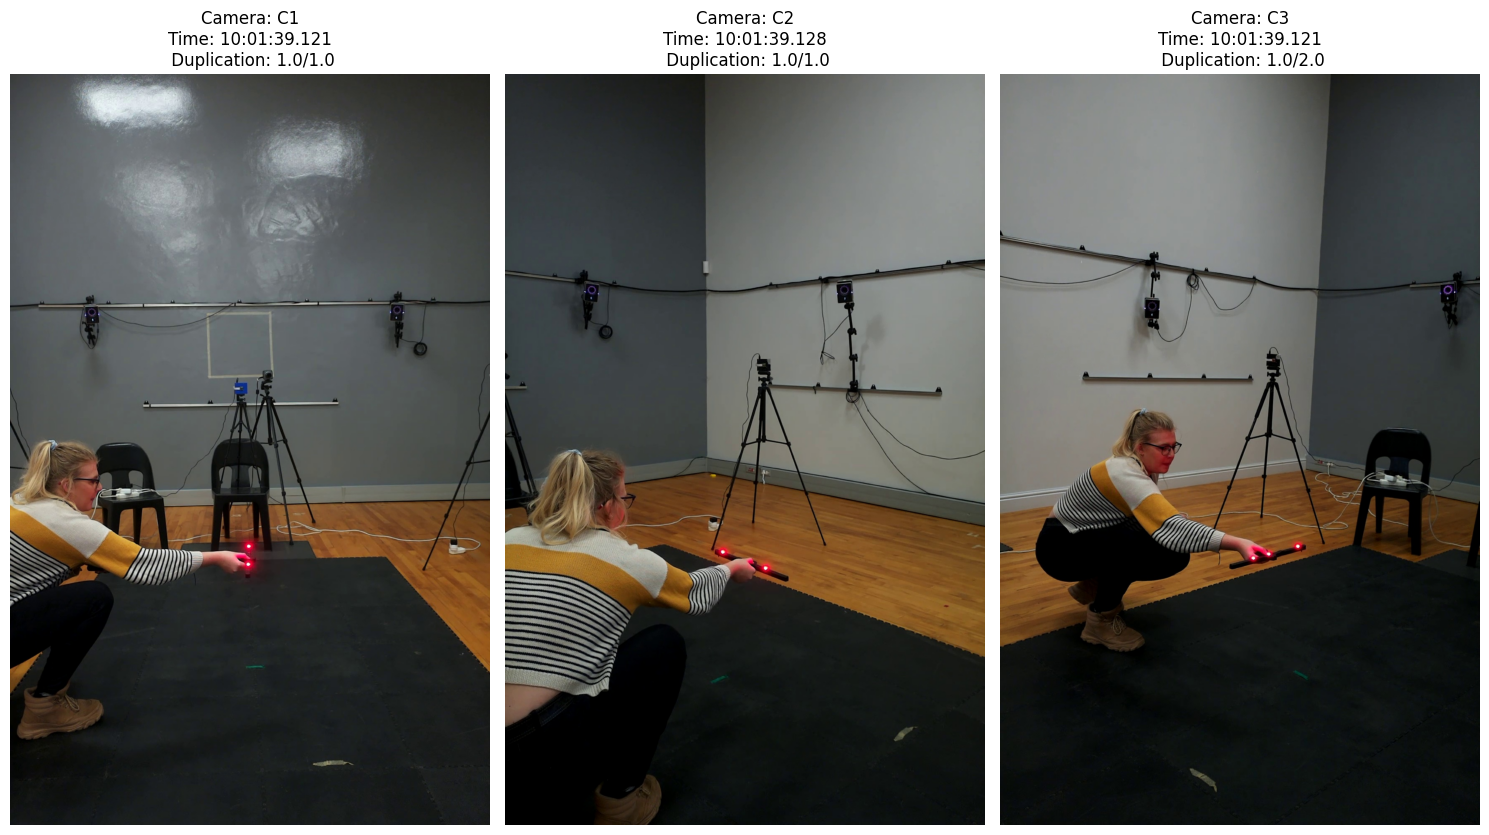

In [12]:
import pandas as pd
from datetime import datetime
import cv2
import matplotlib.pyplot as plt

df = pd.read_csv(f'{root_path}data/times/all_times_w_drops.csv')
df = df[df['camera'].isin(['C1', 'C2', 'C3'])]
df['path'] = df.apply(lambda x: f'frames/{x["camera"]}/{x["combination"]}/{x["combination"]}_{str(x["frame_num"]).zfill(4)}.jpg', axis=1)

num = 3013
combination = 'C1S1A1D1'

df = df[df['combination'].isin([combination, combination.replace('C1', 'C2'), combination.replace('C1', 'C3')])].copy()

# Step 1: Extract the camera and time information from the given path
def extract_info_from_path(df, num, combintation):
    camera = df.loc[(df['frame_num'] == num) & (df['combination'] == combintation), 'camera'].values[0]
    # Extract the time string corresponding to the path
    time_str = df.loc[(df['frame_num'] == num) & (df['combination'] == combintation), 'time'].values[0]
    time_obj = datetime.strptime(time_str, '%H:%M:%S.%f')
    return camera, time_obj

try:
    given_camera, given_time = extract_info_from_path(df, num, combination)
except ValueError as e:
    print(e)
    given_camera, given_time = None, None

if given_time:
    # Step 2: Convert the `time` column in the DataFrame to `datetime` objects
    df['time_obj'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f')

    # Step 3: Find the closest path for each unique camera
    closest_paths = {}

    for camera in df['camera'].unique():
        camera_df = df[df['camera'] == camera]
        # Find the row with the minimum time difference
        closest_row = camera_df.iloc[(camera_df['time_obj'] - given_time).abs().argmin()]
        # closest_paths[camera] = closest_row['path']
        closest_paths[camera] = f"{root_path}frames/{closest_row['camera']}/{closest_row['combination']}/{closest_row['combination']}_{str(closest_row['frame_num']).zfill(4)}.jpg"

    print(f"Given combination & frame: {combination} - {num}" )
    print("Closest paths for each unique camera:")
    for cam, path in closest_paths.items():
        print(f"Camera: {cam}, Path: {path}")

    # Plotting images with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))
    axes = axes.ravel()  # Flatten the array of axes for easy iteration

    for i, (camera, path) in enumerate(closest_paths.items()):
        # Read the image using OpenCV
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Extract the corresponding time for the title
        time_str = df.loc[df['path'] == path, 'time'].values[0]
        dup_num = df.loc[df['path'] == path, 'dup_num'].values[0]
        factor = df.loc[df['path'] == path, 'factor'].values[0]
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].set_title(f'Camera: {camera}\nTime: {time_str}\n Duplication: {dup_num}/{factor}')
        axes[i].axis('off')  # Hide the axes

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("No valid given time to process.")

In [19]:
import json
import pandas as pd
from datetime import datetime
from fastprogress import progress_bar

# Load JSON and CSV data
with open(f'{root_path}data/times/stomp_refine_manual.json', 'r') as f:
    stomp_refine_all = json.load(f)

df = pd.read_csv(f'{root_path}data/times/all_times_w_drops.csv')

# Ensure the time column is properly converted to datetime
df['time_obj'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f')


In [22]:
# Function to extract camera and time
def extract_info_from_path(df, num, combination):
    row = df.loc[(df['frame_num'] == num) & (df['combination'] == combination)]
    if row.empty:
        return None, None
    camera = row['camera'].values[0]
    time_str = row['time'].values[0]
    time_obj = datetime.strptime(time_str, '%H:%M:%S.%f')
    return camera, time_obj

# Dictionary to store the new data
new_dict = {}

stomp_refine_all = {
    "C4S9A6D2": stomp_refine_all['C4S9A6D2']
}

# Process each key-value pair in the JSON
for key, val in progress_bar(stomp_refine_all.items(), total=len(stomp_refine_all)):
    start_idx = val['first_idx']
    end_idx = val['last_idx']
    group_id = key.replace('C4', '')

    df_temp = df[df['group_id'] == group_id].copy()
    
    # Process start index
    try:
        given_camera, given_time = extract_info_from_path(df_temp, start_idx, key)
    except Exception as e:
        print(e)
        given_camera, given_time = None, None

    if given_camera is None:
        continue
    
    closest_paths = {}
    for camera in df_temp['camera'].unique():
        camera_df = df_temp.loc[df_temp['camera'] == camera].copy()
        camera_df['time_diff'] = (camera_df['time_obj'] - given_time).abs()
        closest_row = camera_df.loc[camera_df['time_diff'].idxmin()]
        closest_paths[camera] = closest_row['path']
        combination_temp = closest_row['combination']
        idx_temp = closest_row['frame_num']
        if combination_temp not in new_dict:
            new_dict[combination_temp] = {}
        new_dict[combination_temp]['first_idx'] = idx_temp

    # Process end index
    try:
        given_camera, given_time = extract_info_from_path(df_temp, end_idx, key)
    except Exception as e:
        print(e)
        given_camera, given_time = None, None

    if given_camera is None:
        continue
    
    for camera in df_temp['camera'].unique():
        camera_df = df_temp.loc[df_temp['camera'] == camera].copy()
        camera_df['time_diff'] = (camera_df['time_obj'] - given_time).abs()
        closest_row = camera_df.loc[camera_df['time_diff'].idxmin()]
        closest_paths[camera] = closest_row['path']
        combination_temp = closest_row['combination']
        idx_temp = closest_row['frame_num']
        if combination_temp not in new_dict:
            new_dict[combination_temp] = {}
        new_dict[combination_temp]['last_idx'] = idx_temp

    new_dict = {k: {subk: int(subv) for subk, subv in v.items()} for k, v in new_dict.items()}

new_dict

{'C1S9A6D2': {'first_idx': 274},
 'C2S9A6D2': {'first_idx': 262},
 'C3S9A6D2': {'first_idx': 264, 'last_idx': 1400},
 'C4S9A6D2': {'first_idx': 267},
 'C5S9A6D2': {'first_idx': 269},
 'C6S9A6D2': {'first_idx': 208},
 'C1S21A7D2': {'last_idx': 937},
 'C2S21A7D2': {'last_idx': 983},
 'C4S21A7D2': {'last_idx': 1026},
 'C5S21A7D2': {'last_idx': 961},
 'C6S21A7D2': {'last_idx': 999}}

In [26]:
import pandas as pd
from datetime import datetime
import cv2
import matplotlib.pyplot as plt

df = pd.read_csv(f'{root_path}data/times/all_times_w_drops.csv')
df = df[df['camera'].isin(['C1', 'C2', 'C3'])]
df['path'] = df.apply(lambda x: f'frames/{x["camera"]}/{x["combination"]}/{x["combination"]}_{str(x["frame_num"]).zfill(4)}.jpg', axis=1)


In [27]:
num_start = 418
num_end = 3013
combination = 'C1S1A1D1'

df_temp = df[df['combination'] == combination].copy()
df_temp = df_temp[(df_temp['frame_num'] >= num_start) & (df_temp['frame_num'] <= num_end)].copy()
print(len(df_temp['frame_num'].unique()))
print(len(df_temp))
#sum not 1 factors
# print(df_temp[~(df_temp['factor']==1)]['factor'].sum())
print(len(df_temp)-len(df_temp['frame_num'].unique()))
#print strat and end factors
print(df_temp[df_temp['frame_num'] == num_start]['factor'].values[0])
print(df_temp[df_temp['frame_num'] == num_end]['factor'].values[0])
df_temp['time_diff_original'].describe()

2596
3387
791
1.0
1.0


count    3387.000000
mean       27.115556
std        12.068169
min        17.768000
25%        17.850000
50%        17.852000
75%        35.701000
max       107.103000
Name: time_diff_original, dtype: float64

In [28]:
num_start = 426
num_end = 3074
combination = 'C2S1A1D1'

df_temp = df[df['combination'] == combination].copy()
df_temp = df_temp[(df_temp['frame_num'] >= num_start) & (df_temp['frame_num'] <= num_end)].copy()
print(len(df_temp['frame_num'].unique()))
print(len(df_temp))
#sum not 1 factors
# print(df_temp[~(df_temp['factor']==1)]['factor'].sum())
print(len(df_temp)-len(df_temp['frame_num'].unique()))
#print strat and end factors
print(df_temp[df_temp['frame_num'] == num_start]['factor'].values[0])
print(df_temp[df_temp['frame_num'] == num_end]['factor'].values[0])
df_temp['time_diff_original'].describe()

2649
3389
740
1.0
1.0


count    3389.000000
mean       27.257632
std        14.269119
min        17.523000
25%        17.850000
50%        17.852000
75%        35.702000
max       124.952000
Name: time_diff_original, dtype: float64

In [29]:
num_start = 369
num_end = 2919
combination = 'C3S1A1D1'

df_temp = df[df['combination'] == combination].copy()
df_temp = df_temp[(df_temp['frame_num'] >= num_start) & (df_temp['frame_num'] <= num_end)].copy()
print(len(df_temp['frame_num'].unique()))
print(len(df_temp))
#sum not 1 factors
# print(df_temp[~(df_temp['factor']==1)]['factor'].sum())
print(len(df_temp)-len(df_temp['frame_num'].unique()))
#print strat and end factors
print(df_temp[df_temp['frame_num'] == num_start]['factor'].values[0])
print(df_temp[df_temp['frame_num'] == num_end]['factor'].values[0])
df_temp['time_diff_original'].describe()

2551
3388
837
1.0
2.0


count    3388.000000
mean       27.703023
std        12.199585
min        17.715000
25%        17.850000
50%        17.853000
75%        35.701000
max        89.252000
Name: time_diff_original, dtype: float64

In [26]:
import json
import pandas as pd
from datetime import datetime
from fastprogress import progress_bar

# Load JSON and CSV data
with open(f'{root_path}data/stomp_sync_init.json', 'r') as f:
    stomp_refine_all = json.load(f)

df = pd.read_csv(f'{root_path}data/times/all_times_w_drops.csv')

data=[]

for key, val in progress_bar(stomp_refine_all.items(), total=len(stomp_refine_all)):
    start_idx = val['first_idx_w_drop']
    end_idx = val['last_idx_w_drop']
    combination = key
    group_id = key[2:]

    num_frames_w_drop = len(df[(df['combination'] == combination) & (df['frame_num_w_drop'] >= start_idx) & (df['frame_num_w_drop'] <= end_idx)])
    data.append({'camera': combination[:2], 'group_id': group_id, 'combination': combination, 'num_frames_w_drop': num_frames_w_drop})

df_new = pd.DataFrame(data)
#sort
df_new = df_new.sort_values(by=['group_id', 'camera'])

df_new.head(20)



,camera,group_id,combination,num_frames_w_drop
828,C1,S10A1D1,C1S10A1D1,1452
829,C2,S10A1D1,C2S10A1D1,1452
830,C3,S10A1D1,C3S10A1D1,1452
831,C4,S10A1D1,C4S10A1D1,1452
832,C5,S10A1D1,C5S10A1D1,1452
833,C6,S10A1D1,C6S10A1D1,1452
882,C1,S10A1D2,C1S10A1D2,1157
883,C2,S10A1D2,C2S10A1D2,1157
884,C3,S10A1D2,C3S10A1D2,1157
885,C4,S10A1D2,C4S10A1D2,1157


In [28]:
group_counts = df_new.groupby('group_id')['num_frames_w_drop'].transform('nunique')
filtered_df = df_new[group_counts > 1]
print(len(df_new['group_id'].unique()))
print(len(filtered_df['group_id'].unique()))
filtered_df.head(20)

638
95


,camera,group_id,combination,num_frames_w_drop
792,C1,S10A4D1,C1S10A4D1,1320
793,C2,S10A4D1,C2S10A4D1,1319
794,C3,S10A4D1,C3S10A4D1,1319
795,C4,S10A4D1,C4S10A4D1,1319
796,C5,S10A4D1,C5S10A4D1,1319
797,C6,S10A4D1,C6S10A4D1,1319
834,C1,S10A7D3,C1S10A7D3,1075
835,C2,S10A7D3,C2S10A7D3,1075
836,C3,S10A7D3,C3S10A7D3,1075
837,C4,S10A7D3,C4S10A7D3,1075


In [ ]:
import json
import pandas as pd
from datetime import datetime
from fastprogress import progress_bar

# Load JSON and CSV data
with open(f'{root_path}data/stomp_sync_init.json', 'r') as f:
    stomp_sync_init = json.load(f)

with open(f'{root_path}data/stomp_sync_refine.json', 'r') as f:
    stomp_sync_refine = json.load(f)

df = pd.read_csv(f'{root_path}data/times/all_times_w_drops.csv')

data=[]

for key, val in progress_bar(stomp_sync_refine.items(), total=len(stomp_sync_refine)):
    start_idx = val
    combination = key
    group_id = key[2:]

    c4_start_idx = stomp_sync_init[key]

    num_frames_w_drop = len(df[(df['combination'] == combination) & (df['frame_num_w_drop'] >= start_idx) & (df['frame_num_w_drop'] <= end_idx)])